In [ ]:
from icrawler.builtin import GoogleImageCrawler

# your_root_dir에 저장할 경로 쓰기. 이미지별로 폴더를 따로 만들 것
google_crawler = GoogleImageCrawler(storage={'root_dir': 'your_image_dir'})
# 검색할 키워드와 최대 이미지 개수
google_crawler.crawl(keyword='cat', max_num=100)
google_crawler = GoogleImageCrawler(storage={'root_dir': 'cat'})

google_crawler.crawl(keyword='dog', max_num=100)
google_crawler = GoogleImageCrawler(storage={'root_dir': 'dog'})

google_crawler.crawl(keyword='bear', max_num=100)
google_crawler = GoogleImageCrawler(storage={'root_dir': 'bear'})




['bear', 'dog', 'fox']
bear  dog  bear  bear
EPOCH 1:
LOSS train 0.0 valid 1.239378571510315
EPOCH 2:
LOSS train 0.0 valid 1.1981196403503418
EPOCH 3:
LOSS train 0.0 valid 1.0347998142242432
EPOCH 4:
LOSS train 0.0 valid 1.2137705087661743
EPOCH 5:
LOSS train 0.0 valid 1.305957317352295


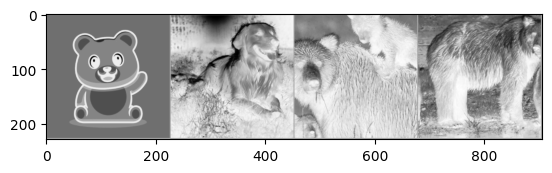

In [3]:
import torch
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

transform = ShuffleNet_V2_X0_5_Weights.DEFAULT.transforms()
model = shufflenet_v2_x0_5()

imagefolder = ImageFolder("root",transform=transform)
# 분류된 항목 이름을 폴더 이름 순서대로 나열해준다.
classes = imagefolder.classes
print(classes)

# 훈련과 검증셋으로 나누기
cut = int(len(imagefolder)*0.8)
training_set, validating_set = random_split(imagefolder,[cut,len(imagefolder)-cut])

# 데이터로더로 만들기
training_loader = DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = DataLoader(validating_set, batch_size=4, shuffle=True)

# 잘 불러왔는지 확인해보기
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# 이미지 출력을 돕는 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)),vmin=0,vmax=255)

dataiter = iter(training_loader)
images, labels = dataiter.next()

# 그리드 모양으로 이미지 나타내기
img_grid = make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# 순서대로 어떤 이미지인지 이름을 출력
print('  '.join(classes[labels[j]] for j in range(4)))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 전체 스텝을 계산하기 위한 epoch 회차와 텐서보드를 매개변수로 받음
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # 배치 데이터를 번호 붙여 뽑기. 중복없이 모두 뽑을 때까지 맞춰 뽑음.
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델로 예측
        outputs = model(inputs)

        # 예측 결과와 실제 답의 차이를 손실함수로 계산
        loss = loss_fn(outputs, labels)
        # 손실함수 값을 역전파
        loss.backward()

        # 역전파 된 그래디언트 값을 최적화함수로 적용
        optimizer.step()

        # 1000개의 배치마다 리포트를 위한 데이터 값 추출. 손실 값을 통계내어 출력 및 내보냄.
        running_loss += loss.item()
        # 0번부터 시작이기 때문
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # 손실 평균
            print(f'  batch {i + 1} loss: {last_loss}')
            # 실제 스텝 번호
            tb_x = epoch_index * len(training_loader) + i + 1
            # 텐서보드에 Loss/train값으로 기록
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

    # 날짜와 시간를 넣어 텐서보드 시작하기
run_id = 'train 1'
writer = SummaryWriter(f'runs/{run_id}')
# 시작 epoch 값
epoch_number = 0

EPOCHS = 5

# 가장 좋은 결과값 기록. _언더바는 천단위 구분하는 콤마,와 같은 편의상의 기호.
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # 훈련모드로 들어가 훈련. 그래디언트를 계산하고 가중치에 변화를 줄 수 있음.
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # 훈련모드를 종료. 그래디언트를 계산하지 않음.
    model.train(False)

    running_vloss = 0.0
    # 검증 데이터로 검증
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    # 훈련 및 검증 데이터에 대한 평균 손실에 대한 로그 데이터를 텐서보드에 기록함
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # 에포크 별로 가장 좋은 성능을 보인 모델에 대해 저장함.
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{epoch_number}'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

    model_path = '마지막 저장 지점과 에포크 넘버'

# 모델을 pt파일로 저장
model_scripted = torch.jit.script(model) # TorchScript로 내보내기
model_scripted.save('model_scripted.pt') # 저장. 저장할 파일 이름 지정

